### in this notebook we'll try to make some changes to the vggnet model. instead of increasing the kernel size of all the layers as we did in model3, we'll increase the kernel size for the first couple of layers to 5, and keep it as 3 for the latter layers. becaues padding 2 and kernel size 5 on an image of size 3 (for the final layers), may not be so good

vgg model source : github [link](https://github.com/usef-kh/fer/tree/master/models)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import os

In [7]:
class FERdataset(Dataset):
    def __init__(self, path_fer2013csv, path_fer2013newcsv):
        self.fer2013 = pd.read_csv(path_fer2013csv)
        self.fer2013labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
        self.fer2013new = pd.read_csv(path_fer2013newcsv)
        self.fer2013newlabels = list(self.fer2013new.columns[2:11])
        
    def __getitem__(self, index):
        '''
        returns an image and its fer2013new label as tensors
        '''
        image = self.fer2013['pixels'].iloc[index]
        image = np.fromstring(image, sep=' ').reshape(48, 48)
        image = torch.tensor(image, dtype=torch.float32) / 255
        
        label = torch.tensor(self.fer2013new.iloc[index][2:11].values.astype('float32')) / 10
        
        return image, label
        
    def __len__(self):
        return self.fer2013.shape[0]
    

In [8]:
!ls

drive  sample_data


In [9]:
!unzip /content/drive/MyDrive/TSI/Material/Thesis/data/data.zip

Archive:  /content/drive/MyDrive/TSI/Material/Thesis/data/data.zip
   creating: data/
   creating: data/FERplus/
  inflating: data/FERplus/.gitignore  
  inflating: data/FERplus/fer2013new.csv  
   creating: data/fer2013/
  inflating: data/fer2013/.gitignore  
  inflating: data/fer2013/fer2013.csv  
  inflating: data/fer2013/README     
  inflating: data/fer2013/fer2013.bib  
  inflating: data/fer2013/README.md  


In [10]:
!ls

data  drive  sample_data


In [11]:
path_fer2013csv='data/fer2013/fer2013.csv'
path_fer2013newcsv='data/FERplus/fer2013new.csv'
dataset = FERdataset(path_fer2013csv, path_fer2013newcsv)

In [12]:
from torch.utils.data import random_split

In [13]:
traindataset, valdataset, testdataset = random_split(dataset, [int(0.6*len(dataset)), int(0.2*len(dataset)), len(dataset) - (int(0.6*len(dataset)) + int(0.2*len(dataset)))], generator=torch.Generator().manual_seed(42))

In [14]:
print(f'traindataset length: {len(traindataset)}')
print(f'valdataset length: {len(valdataset)}')
print(f'testdataset length: {len(testdataset)}')

traindataset length: 21532
valdataset length: 7177
testdataset length: 7178


In [15]:
len(dataset.fer2013newlabels)

9

In [16]:
class Model4(nn.Module):
    def __init__(self, drop=0.2):
        super().__init__()

        self.conv1a = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=5, padding=2)
        self.conv1b = nn.Conv2d(64, out_channels=64, kernel_size=5, padding=2)

        self.conv2a = nn.Conv2d(64, 128, 5, padding=2)
        self.conv2b = nn.Conv2d(128, 128, 5, padding=2)

        self.conv3a = nn.Conv2d(128, 256, 3, padding=1)
        self.conv3b = nn.Conv2d(256, 256, 3, padding=1)

        self.conv4a = nn.Conv2d(256, 512, 3, padding=1)
        self.conv4b = nn.Conv2d(512, 512, 3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bn1a = nn.BatchNorm2d(64)
        self.bn1b = nn.BatchNorm2d(64)

        self.bn2a = nn.BatchNorm2d(128)
        self.bn2b = nn.BatchNorm2d(128)

        self.bn3a = nn.BatchNorm2d(256)
        self.bn3b = nn.BatchNorm2d(256)

        self.bn4a = nn.BatchNorm2d(512)
        self.bn4b = nn.BatchNorm2d(512)

        # self.lin1 = nn.Linear(512 * 2 * 2, 4096)
        self.lin1 = nn.Linear(512 * 3 * 3, 4096)
        self.lin2 = nn.Linear(4096, 4096)

        # self.lin3 = nn.Linear(4096, 7)
        # output size changed to 9 because we're using the fer plus labels, not the fer 2013 labels
        self.lin3 = nn.Linear(4096, 9)

        self.drop = nn.Dropout(p=drop)

    def forward(self, x):
        x = F.relu(self.bn1a(self.conv1a(x)))
        x = F.relu(self.bn1b(self.conv1b(x)))
        x = self.pool(x)

        x = F.relu(self.bn2a(self.conv2a(x)))
        x = F.relu(self.bn2b(self.conv2b(x)))
        x = self.pool(x)

        x = F.relu(self.bn3a(self.conv3a(x)))
        x = F.relu(self.bn3b(self.conv3b(x)))
        x = self.pool(x)

        x = F.relu(self.bn4a(self.conv4a(x)))
        x = F.relu(self.bn4b(self.conv4b(x)))
        x = self.pool(x)
        
        # x = x.view(-1, 512 * 2 * 2) - replaced by torch.flatten
        x = torch.flatten(x, 1)
        x = F.relu(self.drop(self.lin1(x)))
        x = F.relu(self.drop(self.lin2(x)))
        x = self.lin3(x)
        
        return x

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [18]:
model4 = Model4().to(device)

In [19]:
model4

Model4(
  (conv1a): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv1b): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2a): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2b): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3a): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3b): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4a): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4b): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1a): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn1b): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2a): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [20]:
torch.cuda.is_available()

True

In [21]:
# parameters
epochs = 20
batch_size = 100

In [22]:
trainloader = DataLoader(traindataset, batch_size, shuffle=True)
valloader = DataLoader(valdataset, batch_size, shuffle=True)

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model4.parameters())

In [24]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

In [25]:
running_loss = []
running_val_loss = []
alltrainacc = []
allvalacc = []

print_every = 20
for e in range(epochs):
    for i,(images, labels) in enumerate(trainloader):
        model4.train()
        images.unsqueeze_(1)
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        output = model4(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss.append(loss.item())
        
        if i%print_every == 0:
            # torch.save(vggmodel.state_dict(), os.path.join('/models', 'decoder-%d.pkl' % i))
            model4.eval()
            with torch.no_grad():
                for j,(valimages, vallabels) in enumerate(valloader):
                    val_loss_list = []
                    valimages.unsqueeze_(1)
                    valimages = valimages.to(device)
                    vallabels = vallabels.to(device)
                    
                    val_output = model4(valimages)
                    val_loss = criterion(val_output, vallabels)

                    val_loss_list.append(val_loss.item())
                    
                    # to calculate training accuracy
                    trueargmax = torch.argmax(labels, dim=1)
                    truelabels = trueargmax.cpu().detach().numpy()
                    predargmax = torch.argmax(output, dim=1)
                    predlabels = predargmax.cpu().detach().numpy()
                    
                    # to calculate validation accuracy
                    valtrueargmax = torch.argmax(vallabels, dim=1)
                    valtruelabels = valtrueargmax.cpu().detach().numpy()
                    valpredargmax = torch.argmax(val_output, dim=1)
                    valpredlabels = valpredargmax.cpu().detach().numpy()                    

                val_loss_avg = sum(val_loss_list) / len(val_loss_list)
                
            # calculate training and validation accuracy
            batchtrainacc = accuracy_score(truelabels, predlabels)
            batchvalacc = accuracy_score(valtruelabels, valpredlabels)
            
            # store the training and validation accuracies 
            alltrainacc.append(batchtrainacc)
            allvalacc.append(batchvalacc)

            running_val_loss.append(val_loss_avg)
            print(f'epoch: {e}, iteration: {i}, loss: {loss.item():.5f}, val_loss: {val_loss_avg:.5f}, acc: {batchtrainacc:.5f}, val_acc: {batchvalacc:.5f}')

epoch: 0, iteration: 0, loss: 2.21612, val_loss: 1.92442, acc: 0.11000, val_acc: 0.29870
epoch: 0, iteration: 20, loss: 1.88002, val_loss: 1.85309, acc: 0.39000, val_acc: 0.33766
epoch: 0, iteration: 40, loss: 1.85911, val_loss: 1.82963, acc: 0.30000, val_acc: 0.24675
epoch: 0, iteration: 60, loss: 1.77988, val_loss: 1.77226, acc: 0.47000, val_acc: 0.35065
epoch: 0, iteration: 80, loss: 1.78902, val_loss: 1.79353, acc: 0.27000, val_acc: 0.35065
epoch: 0, iteration: 100, loss: 1.81690, val_loss: 1.79803, acc: 0.46000, val_acc: 0.45455
epoch: 0, iteration: 120, loss: 1.82825, val_loss: 1.79912, acc: 0.43000, val_acc: 0.35065
epoch: 0, iteration: 140, loss: 1.76359, val_loss: 1.67930, acc: 0.48000, val_acc: 0.41558
epoch: 0, iteration: 160, loss: 1.81371, val_loss: 1.74724, acc: 0.38000, val_acc: 0.42857
epoch: 0, iteration: 180, loss: 1.78824, val_loss: 1.92451, acc: 0.38000, val_acc: 0.25974
epoch: 0, iteration: 200, loss: 1.79097, val_loss: 1.81098, acc: 0.34000, val_acc: 0.23377
epoch

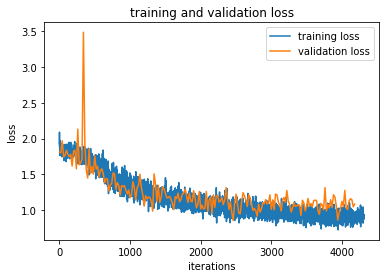

In [26]:
ind = 10
plt.plot(np.arange(len(running_loss[ind:])), running_loss[ind:], label='training loss')
plt.plot(np.arange(len(running_val_loss[ind:]))*print_every, running_val_loss[10:], label='validation loss')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

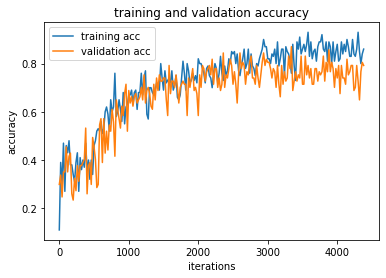

In [27]:
plt.plot(np.arange(len(alltrainacc))*print_every, alltrainacc, label='training acc')
plt.plot(np.arange(len(allvalacc))*print_every, allvalacc, label='validation acc')
plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.title('training and validation accuracy')
plt.legend()
plt.show()

### Let's run the model on the test data

In [28]:
testloader = DataLoader(testdataset, 1, shuffle=False)

In [30]:
model4.eval()
testtruelabels = []
testpredlabels = []
with torch.no_grad():
    for i, (testimage, testlabel) in enumerate(testloader):
        testimage.unsqueeze_(1)
        testimage, testlabel = testimage.to(device), testlabel.to(device)
        testpred = model4(testimage)

        testtrueargmax = torch.argmax(testlabel).item()
        testpredargmax = torch.argmax(testpred).item()

        testtruelabels.append(testtrueargmax)
        testpredlabels.append(testpredargmax)

In [31]:
testconfmat = confusion_matrix(testtruelabels, testpredlabels)

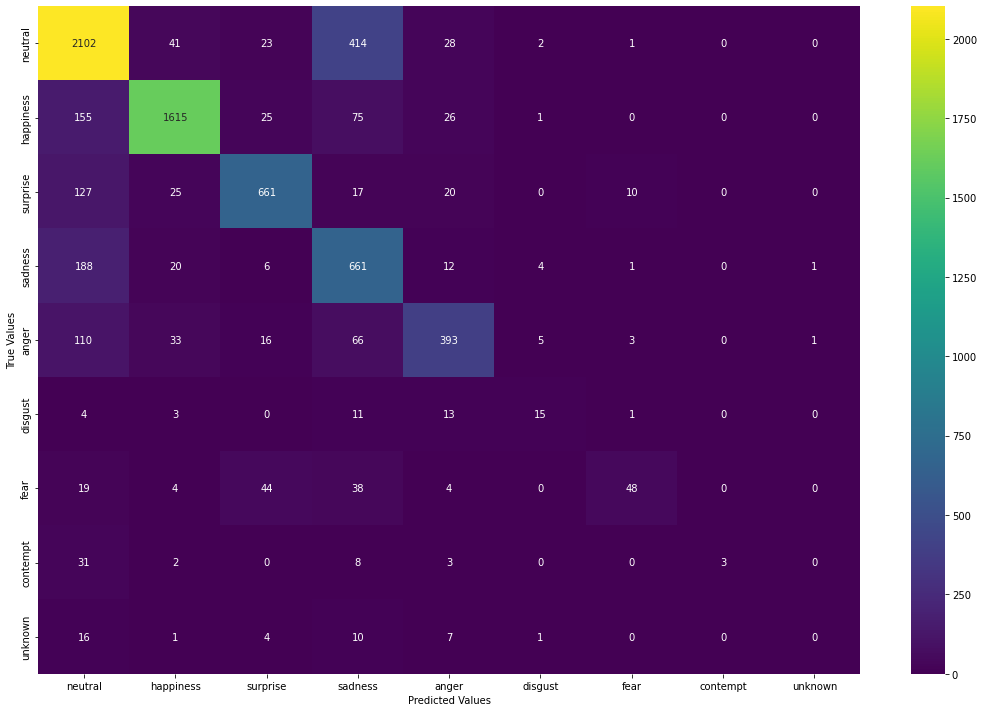

In [32]:
plt.figure(figsize=(15,10))
sns.heatmap(testconfmat, annot=True, fmt='.0f', cmap='viridis', xticklabels=dataset.fer2013newlabels, yticklabels=dataset.fer2013newlabels)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.tight_layout()
plt.show()

In [33]:
accuracy_score(testtruelabels, testpredlabels)

0.7659515185288381

In [34]:
torch.save(model4.state_dict(), f'/content/drive/MyDrive/TSI/Material/Thesis/data/model4_state_dict.pth')